# Multi-Agent Deep Deterministic Policy Gradient

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from IPython.display import clear_output
from collections import namedtuple, deque

import multiagent.scenarios as scenarios
from multiagent.environment import MultiAgentEnv

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
from noise import OUNoise
from model import ActorCriticNetwork
from buffer import ReplayBuffer

In [4]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [5]:
plt.style.use('ggplot')

## Set Config

In [6]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [7]:
BUFFER_SIZE = int(1e6)
BATCH_SIZE = 32
GAMMA = 0.99
TAU = 1e-2
PRINT_EVERY = 10
UPDATE_EVERY = 3

# actor & critic network have different learning rates
LR_ACTOR = 1e-4
LR_CRITIC = 1e-3
WEIGHT_DECAY = 0.0 # L2 weight decay

# noise settings
GRAD_CLIP = 0.5
NOISE_START = 0.5
NOISE_DECAY = 1.0
TIME_STOP_NOISE = int(3e4)

## Set Environment

In [8]:
SCENARIO_NAME = 'simple_spread'

In [9]:
def make_env(scenario_name, benchmark=False):
    
    scenario = scenarios.load(scenario_name + '.py').Scenario()
    
    world = scenario.make_world()
    
    if benchmark:
        env = MultiAgentEnv(world, scenario.reset_world, scenario.reward, scenario.observation, scenario.benchmark_data)
    else:
        env = MultiAgentEnv(world, scenario.reset_world, scenario.reward, scenario.observation)
        
    return env

In [10]:
env = make_env(scenario_name=SCENARIO_NAME)

In [11]:
print('Environment Info')
state_size = env.observation_space[0].shape[0]
action_size = env.action_space[0].n

print('Number of agents: {}'.format(env.n))
print('State space: {}'.format(state_size))
print('Action space: {}'.format(action_size))

Environment Info
Number of agents: 3
State space: 18
Action space: 5


## Define [MADDPG](https://arxiv.org/pdf/1706.02275.pdf) Agent

In [12]:
class DDPGAgent():
    """The Agent that will interacts with and learns from the environment."""

    def __init__(self, agent_id, model, state_size, action_size, seed):
        """Initialize an DDPG Agent object."""
        
        self.agent_id = agent_id
        
        self.state_size = state_size
        self.action_size = action_size
        
        self.lr_actor = LR_ACTOR
        self.lr_critic = LR_CRITIC
        self.weight_decay = WEIGHT_DECAY
        self.tau = TAU
        self.grad_clip = GRAD_CLIP
        
        # initialize actor and critic networks
        self.actor = model.actor.to(device)
        self.actor_target = model.actor_target.to(device)
        
        self.critic = model.critic.to(device)
        self.critic_target = model.critic_target.to(device)
            
        # set optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.lr_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.lr_critic, weight_decay=self.weight_decay)
        
        # set weights for local and target actor, respectively, critic the same
        self.soft_update(self.actor, self.actor_target, 1)
        self.soft_update(self.critic, self.critic_target, 1)
        
        # introduce noise process
        self.noise = OUNoise(self.action_size, seed)
        
    def act(self, states, noise_weight=1.0, add_noise=True):
        """Return action for given state as per current policy."""
        
        states = torch.FloatTensor(states).to(device)
        self.actor.eval()
        with torch.no_grad():
            actions = self.actor(states).cpu().data.numpy()
        self.actor.train()
        
        if add_noise==True:
            self.noise_value = self.noise.sample() * noise_weight
            actions += self.noise_value
        
        actions = np.clip(actions, -1, 1)
        
        return actions
    
    def reset(self):
        """Reset noise parameters."""
        self.noise.reset()
        
    def learn(self, agent_id, experiences, gamma, all_actions, all_next_actions):
        """Update policy and value parameters using given batch of experience tuples."""
        
        states, actions, rewards, next_states, dones = experiences
        
        # get the agent id
        agent_id = torch.tensor([agent_id]).to(device)
        
        # obtain Q expected
        Q_expected = self.critic(states, actions)
        
        next_actions = torch.cat(all_next_actions, dim=1).to(device)
        with torch.no_grad():
            Q_target_next = self.critic_target(next_states, next_actions)
        
        # compute Q target
        Q_targets = rewards.index_select(1, agent_id) + (gamma * Q_target_next * (1 - dones.index_select(1, agent_id)))
        
        # compute value loss
        value_loss = F.mse_loss(Q_expected, Q_targets.detach())
        
        # minimize critic loss
        self.critic_optimizer.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), self.grad_clip)
        self.critic_optimizer.step()
        
        # detach actions from other agents
        actions_pred = [actions if i == self.agent_id else actions.detach() for i, actions in enumerate(all_actions)]
        actions_pred = torch.cat(actions_pred, dim=1).to(device)
        
        # update actor
        policy_loss = -self.critic(states, actions_pred).mean()
        
        # minimize policy loss
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), self.grad_clip)
        self.actor_optimizer.step()
        
        # softly update target networks
        self.soft_update(self.actor, self.actor_target, self.tau)
        self.soft_update(self.critic, self.critic_target, self.tau)
    
    def soft_update(self, local_model, target_model, tau):
        """Softly update model parameters."""
        
        for local_param, target_param in zip(local_model.parameters(), target_model.parameters()):
            target_param.data.copy_(local_param.data * tau + target_param.data * (1.0 - tau))

In [13]:
class MADDPGAgent():
    """The Agent that will interacts with and learns from the environment."""
    
    def __init__(self, env, seed):
        """Initialize an MADDPG Agent object."""
        
        self.env = env
        
        self.state_size = env.observation_space[0].shape[0]
        self.action_size = env.action_space[0].n
        
        self.num_agents = self.env.n
        
        self.buffer_size = BUFFER_SIZE
        self.batch_size = BATCH_SIZE
        self.gamma = GAMMA
        self.noise_weight = NOISE_START
        self.noise_decay = NOISE_DECAY
        self.time_stop_noise = TIME_STOP_NOISE
        self.noise_on = True
        
        # create agents, each with their own actor and critic
        models = [ActorCriticNetwork(self.num_agents, self.state_size, self.action_size, seed) for _ in range(self.num_agents)]
        self.agents = [DDPGAgent(i, models[i], self.state_size, self.action_size, seed) for i in range(self.num_agents)]
        
        # set buffer
        self.buffer = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)
        self.time_step = 0
        
    def act(self, all_states):
        
        # pass each agent's state from the environment and calculate its action
        all_actions = []
        for agent, state in zip(self.agents, all_states):
            actions = agent.act(state, noise_weight=self.noise_weight, add_noise=self.noise_on)
            self.noise_weight *= self.noise_decay
            all_actions.append(actions)
        
        actions = np.array(all_actions)
        
        return actions
        
    def step(self, all_states, all_actions, all_rewards, all_next_states, all_dones):
        
        all_states = np.array(all_states).reshape(1, -1) # reshape 3x18 into 1x54 dimension vector
        all_actions = np.array(all_actions).reshape(1, -1) # reshape 3x5 into 1x15 dimension vector
        all_rewards = np.array(all_rewards).reshape(1, -1) # reshape 3 into 1x3 dimension vector
        all_next_states = np.array(all_next_states).reshape(1, -1) # reshape 3x18 into 1x54 dimension vector
        all_dones = np.array(all_next_states).reshape(1, -1) # reshape 3 into 1x3 dimension vector
        
        self.buffer.add(all_states, all_actions, all_rewards, all_next_states, all_dones)
        
        # if time stop noise are achieved then turning off the noise
        if self.time_step > self.time_stop_noise:
            self.noise_on = False
            
        self.time_step += 1     
        
        # learn every UPDATE_EVERY time steps
        if self.time_step % UPDATE_EVERY == 0:
            # if enough samples are available in memory, get random subset and learn
            
            if len(self.buffer) > BATCH_SIZE:
                
                # sample from the replay buffer of each agent
                experiences = [self.buffer.sample() for _ in range(self.num_agents)]
                self.learn(experiences, self.gamma)
                
    def learn(self, experiences, gamma):
        
        # each agent uses its own actor to calculate next actions
        all_actions = []
        all_next_actions = []

        for i, agent in enumerate(self.agents):
            
            states, _, _, next_states, _ = experiences[i]
            agent_id = torch.tensor([i]).to(device)
            
            # extract agent i's state and get action via actor network
            states = states.reshape(-1, self.num_agents, self.state_size).index_select(1, agent_id).squeeze(1)
            actions = agent.actor(states)
            all_actions.append(actions)
            
            # extract agent i's next state and get action via target action network
            next_states = next_states.reshape(-1, self.num_agents, self.state_size).index_select(1, agent_id).squeeze(1)
            next_actions = agent.actor_target(next_states)
            all_next_actions.append(next_actions)
            
        # each agent learns from its experience sample
        for i, agent in enumerate(self.agents):
            agent.learn(i, experiences[i], gamma, all_actions, all_next_actions)
    
    def save(self, actor_path, critic_path):
        """Save trained agent."""
        if not os.path.exists('./agents/'): os.makedirs('./agents/')
        
        # save actor and critic for each agent
        for i, agent in enumerate(self.agents):
            torch.save(self.agents[i].actor.state_dict(), f'{actor_path}_agent{i}.pth'); torch.save(self.agents[i].critic.state_dict(), f'{critic_path}_agent{i}.pth')
            
    def load(self, actor_path):
        """Load trained agent."""
        for i, agent in enumerate(self.agents):
            self.agents[i].actor.load_state_dict(torch.load(f'{actor_path}_agent{i}.pth'))
            
    def watch(self, num_episodes=10, max_time=1000):
        """Watch trained agent."""
        
        all_scores = []
        
        for i_episode in range(1, num_episodes+1):
        
            all_rewards = []
            states = env.reset()

            for time_step in range(max_time):

                env.render(mode='human')

                actions = agent.act(states)
                next_states, rewards, dones, _ = env.step(actions)

                states = next_states
                all_rewards.append(np.mean(rewards))
                if all(dones):
                    dones = [1 for _ in range(agent.num_agents)]
                    break
                else:
                    dones = [0 for _ in range(agent.num_agents)]

            all_scores.append(np.mean(all_rewards)) # save most recent score to overall score

            print(f'\rEpisode: {i_episode}, Average Score: {np.mean(all_scores):.3f}', end='')
            
        env.close()

In [14]:
agent = MADDPGAgent(env, seed=90)

## Train The Agent

In [15]:
def train_agent(num_episodes=5000, max_time=1000):
    """Train MADDPG agent."""
    
    all_scores = []
    scores_target = 1.0
    scores_window = deque(maxlen=PRINT_EVERY)
    
    for i_episode in range(1, num_episodes+1):
        
        all_rewards = []
        states = env.reset()
        
        for time_step in range(max_time):
            
            actions = agent.act(states)
            next_states, rewards, dones, _ = env.step(actions)
            
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            all_rewards.append(np.mean(rewards))
            if all(dones):
                dones = [1 for _ in range(agent.num_agents)]
                break
            else:
                dones = [0 for _ in range(agent.num_agents)]
        
        all_scores.append(np.mean(all_rewards)) # save most recent score to overall score
        scores_window.append(np.mean(all_rewards)) # save most recent score to running window of last window scores
        
        print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.3f}', end='')
        
        if i_episode % PRINT_EVERY == 0:
            print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.3f}')
        if np.mean(scores_window) >= scores_target:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes! Average Score: {np.mean(scores_window):.3f}')
            break
            
    agent.save(f'./agents/ACTOR_{SCENARIO_NAME}', f'./agents/CRITIC_{SCENARIO_NAME}')
    print('Training completed.')
    
    return all_scores

In [16]:
all_scores = train_agent(num_episodes=1000, max_time=50)

Episode: 10, Average Score: -16.357
Episode: 20, Average Score: -12.491
Episode: 30, Average Score: -12.024
Episode: 40, Average Score: -23.050
Episode: 50, Average Score: -28.529
Episode: 60, Average Score: -20.164
Episode: 70, Average Score: -12.530
Episode: 80, Average Score: -16.726
Episode: 90, Average Score: -16.531
Episode: 100, Average Score: -15.116
Episode: 110, Average Score: -40.193
Episode: 120, Average Score: -16.105
Episode: 130, Average Score: -14.369
Episode: 140, Average Score: -14.275
Episode: 150, Average Score: -11.482
Episode: 160, Average Score: -11.939
Episode: 170, Average Score: -15.309
Episode: 180, Average Score: -14.880
Episode: 190, Average Score: -14.306
Episode: 200, Average Score: -16.149
Episode: 210, Average Score: -12.941
Episode: 220, Average Score: -13.789
Episode: 230, Average Score: -13.168
Episode: 240, Average Score: -12.326
Episode: 250, Average Score: -17.009
Episode: 260, Average Score: -14.067
Episode: 270, Average Score: -9.5679
Episode: 2

## Evaluate The Agent

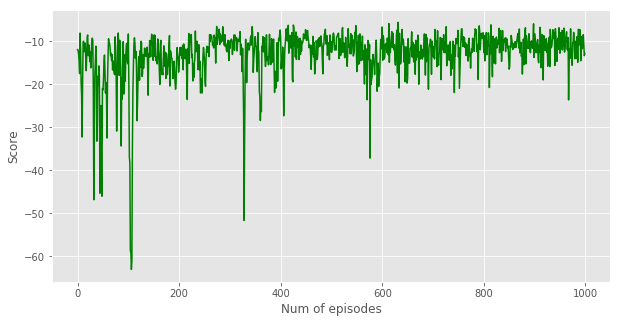

In [17]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(all_scores)), all_scores, color='green')
plt.xlabel('Num of episodes')
plt.ylabel('Score')
if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/plot_of_maddpg_evaluation.png')
plt.show()

## 🎬 Watch The Smart Agent

In [18]:
agent.load(f'./agents/ACTOR_{SCENARIO_NAME}');

In [19]:
agent.watch(num_episodes=10)

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
Episode: 3, Average Score: -12.922agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
Episode: 6, Average Score: -12.917agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to agent 2: _   
agent 1 to agent 0: _   agent 2 to agent 0: _   agent 0 to agent 1: _   agent 2 to agent 1: _   agent 0 to agent 2: _   agent 1 to

---